# Modeling Tiered Pricing Frameworks: A Simulation Approach

### Abstract

This paper examines the tiered pricing model commonly used in drug plans to determine reimbursement prices for generic drugs based on the price of the interchangeable branded drug. By constructing a model reflecting generic drug costs and revenue distribution, the study uses simulations to evaluate different tier structures. Findings reveal that closely packed tiers yield unfavorable welfare outcomes. Transitioning from one to two tiers offers significant welfare benefits, but expanding beyond four tiers yields minimal gains. Thus, for optimal welfare and cost benefits, a tier structure should incorporate a minimum of two tiers.

### Simulation: The Economic Model

The simulation model is based on three main parameters: B, which represents the branded drug's annual revenue before generic entry; C, the variable costs as a percentage of brand market revenues; and F, the annualized fixed costs for a generic company to enter a market. The model predicts generic firm entries in markets based on tiered pricing set by public insurers. This pricing, $p(n)$, where the generic price relative to the brand decreases with more entrants. Assuming brands stop sales post-generic entry, and considering demand elasticity ($\epsilon$), the total generic revenue is $B[1-\epsilon(1-p(n))]p(n)$.

Companies will enter the market if they can profitably cover their fixed costs. The condition for n entries is specified by the inequalities:

$\dfrac{B[1-\epsilon(1-p(n))](p(n)-C)}{2n}-F>0>\dfrac{B[1-\epsilon(1-p(n+1))](p(n+1)-C)}{2n+1}-F$.

In every generic drug market, the number of entrants, n, is influenced by the interplay of B, C, and F, which subsequently establishes a price according to the applied tiered pricing model. The total surplus shift due to entry is threefold. Initially, a price drop minimizes deadweight loss. Next, reduced drug expenditures boost efficiency, especially if the marginal cost of public funds (MCF) exceeds 1. Lastly, the incurred fixed costs from generic entry, denoted by nF, cut down the surplus. The total surplus change from generic entry is computed by aggregating these three factors:


$-\epsilon B (\dfrac{1}{2} + \dfrac{1}{2} p(n)-C)(1-p(n)) + B(1-[1-\epsilon(1-p(n))]p(n))(MCF-1)-nF$.

### Simulation: Market Assumptions

Our first step is to parameterize the distributions of B, C, and F across drug markets.

Before I start coding, I import all the necessary packages.

In [1]:
#The required packages 
import numpy as np
import pandas as pd

from scipy.stats import beta
from scipy.stats import gamma
from scipy.stats import uniform

from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import optimize

from decimal import Decimal

import matplotlib.pyplot as plt

We use a gamma density for market size with $B\propto\Gamma(k,\theta)$, where $k$ denotes shape and $\theta$ scale. We modeled our “small” country based on Canadian data. We fit a gamma distribution to the mean of annual sales of patented drugs in Canada at 3 and 10 years after brand entry.

In [2]:
# Function to calculate the cumulative distribution function (CDF) for the gamma distribution with given shape and scale parameters
def func(x, shape, scale):
    return gamma.cdf(x, shape, scale=scale)

In [3]:
# Estimating the fitted values for shape and scale parameters of the gamma distribution

# Define the maximum annual sales data

Max_annual_sales = {
    'x_10y': [4, 6, 11, 17, 22, 38, 49, 63, 87, 136, 224],
    'x_3y': [2, 3, 5, 8, 12, 17, 23, 32, 41, 62, 108],
    'CDF': [0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
}

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(Max_annual_sales)

# Extract x_3y and x_10y values from the DataFrame
x_3y=df.x_3y
x_10y=df.x_10y

# Calculate the average of x_3y and x_10y
x=(x_3y+x_10y)/2

# Extract CDF values from the DataFrame
y=df.CDF

# Fit the data using the curve_fit function to estimate shape and scale parameters
fitted_values, Estimated_covariance=curve_fit(f=func, xdata=x, ydata=y)

# Extract the shape and scale from the fitted values
shape = fitted_values[0]
scale = fitted_values[1]


# Adjust the scale by multiplying with 1,000,000 for units conversion
scale = scale*1000000

# Adjust the x values similarly for unit consistency
x=x*1000000

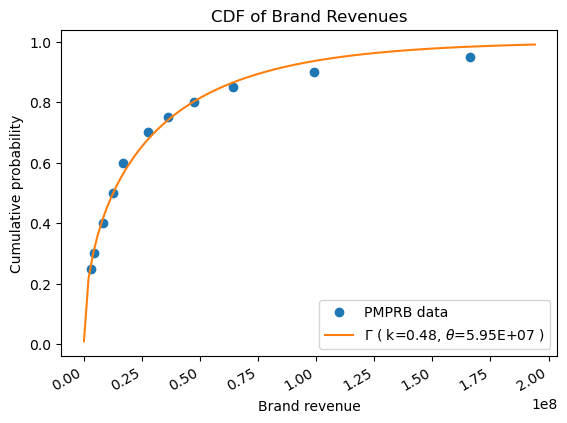

In [4]:
#showing the goodness of the fit

# Generate a sequence of x values for the fitted gamma distribution within 1% to 99% percentiles
x_fitted = np.linspace(gamma.ppf(0.01, shape, scale=scale), gamma.ppf(0.99, shape, scale=scale), 100)

# Compute the cumulative distribution function (CDF) values for the sequence of x values
y_fitted=gamma.cdf(x_fitted, shape , scale=scale)

# Construct the label for the plot with estimated shape and scale parameters
label=r'$\Gamma$'+' ( k='+str(round(shape, 2))+', '+ r'$\theta$'+'='+str('%.2E' % Decimal(scale))+' )'

# Create a new figure and axis for plotting
fig, ax = plt.subplots()

# Plot the original data as dots
ax.plot(x, y, 'o', label='PMPRB data')

# Plot the fitted gamma distribution CDF as a line
ax.plot(x_fitted, y_fitted, label= label)

# Add a legend to the plot
plt.legend()

# Adjust the date format for the x-axis for better visibility
fig.autofmt_xdate()

# Label the x and y axes
plt.xlabel('Brand revenue')
plt.ylabel('Cumulative probability')

# Set the title for the plot
plt.title('CDF of Brand Revenues')

# Display the plot
plt.show()

# Save the figure as a .png file
fig.savefig('Maximum annual sales.png')

# Close the figure to free up memory
plt.close(fig)

From the given data, we derived $k = 0.48$ and $\theta=59.5$ million. Assuming the distribution's shape remains consistent across two countries, we adjusted the gamma distribution's scale parameter for Canada by multiplying it with $17$ to obtain its counterpart for the United States. We've set $\epsilon=-0.14$ and $MCF=1.25$. The distribution of C is modeled using a beta distribution, where $C \propto \beta(a,b)$. Our choice of parameters a and b is influenced by data indicating that, on average, manufacturing costs for brand-name firms account for about $25%$ of their revenues. This led us to select values $a=4$ and $b=12$. The distribution for F, representing the fixed cost of market participation, draws from insights provided by the Generic Prescription Drug Development. We operate under the assumption that in a given market, every generic firm incurs the same fixed costs. However, these costs can differ from one market to another. In every instance, we assume the distributions of B, C, and F to be independent since we haven't found any significant correlation between them. The parameter settings are as follows:

In [5]:
#Set up the parameters

ratio=17 #ratio of the market size of big country to small country. 

b_shape, b_scale = shape, scale #gamma function for B small country
B_shape, B_scale = shape, ratio*scale #gamma function for B large country

C_a, C_b = 4, 12 #beta function for C

F_min,F_max=80000, 800000 #min and max of the fixed cost

e=-0.14 #Elasticity
MCF=1.25 #The marginal cost of public funds (MCF)

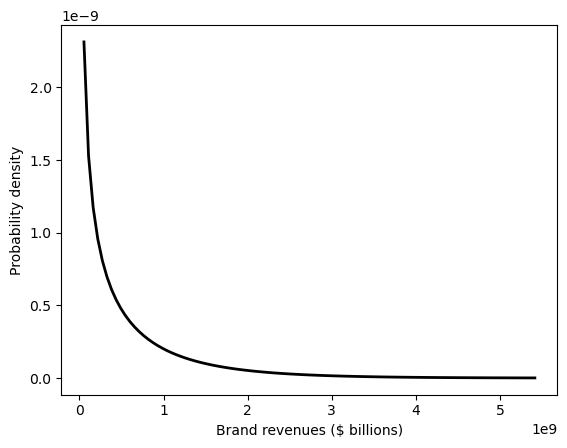

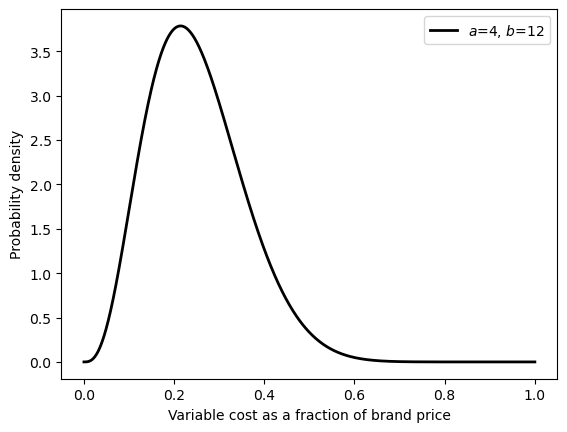

In [6]:
#Plot the probability distributions

#Plot the probability distribution for B
fig, ax = plt.subplots(1, 1)
x = np.linspace(gamma.ppf(0, B_shape, scale=B_scale), gamma.ppf(0.999, B_shape, scale=B_scale), 100)
plt.xlabel('Brand revenues (\$ billions)')
plt.ylabel('Probability density')
ax.plot(x, gamma.pdf(x, B_shape, scale=B_scale),'k-',  lw=2, alpha=1, label='gamma pdf')
fig.savefig('Brand_Revenues.png', dpi=300)

#Plot the probability distribution for C
fig, ax = plt.subplots(1, 1)
x = np.linspace(beta.ppf(0, C_a, C_b), beta.ppf(1, C_a, C_b), 1000)
plt.xlabel('Variable cost as a fraction of brand price')
plt.ylabel('Probability density')
label=r'$a$'+'='+str(C_a)+', '+r'$b$'+'='+str(C_b)
ax.plot(x, beta.pdf(x, C_a, C_b),'k-',  lw=2, alpha=1, label=label)
plt.legend()
fig.savefig('Generic_Variable_Cost.png', dpi=300)

### Simulation: Tiered Pricing Policies

Given this set of market settings, we next apply different tiered pricing policies with different features. The initial step involves generating random samples for each primary variable.

In [7]:
#Random draws for each of the main variables

D=10000 #Number of samples

seed=1 #seed for random generator

B = gamma.rvs(B_shape, scale=B_scale, size=D, random_state=seed) #Brand market size for large countries
b = gamma.rvs(b_shape, scale=b_scale, size=D, random_state=seed) #Brand market size for small countries

C = beta.rvs(C_a, C_b, size=D, random_state=seed) #Generic variable cost

F = uniform.rvs(loc=F_min, scale=(F_max-F_min), size=D, random_state=seed) #Generic entry cost, per year

Next, we establish a function that extracts principal values from each sample, alongside the pricing scheme. This function subsequently provides the number of generic entries and the corresponding price of the generic drug for each sample.

In [8]:
#Function for selecting price from a price scheme for each sample.

def FPS(b,c,f,scheme,e):
    d=len(b) #Number of samples
    scheme = scheme[~np.isnan(scheme)] #Delete NaN value from the scheme
    Ls=len(scheme) #length of the price scheme
    
    Ns=np.zeros(d) #Number of entry for each sample
    Ps=np.ones(d) #Selected price for each sample
    
    #Note below I am assume that market size increases by e times the change in price (i.e. elasticity=-e)
    for i in range(d):
        n=0 
        pn=scheme[0] 
        pn1=scheme[1] #price of the next entry
        pi=pn1-c[i]-((f[i])/(b[i]*(1-e*(1-pn1)))) #profit of the first entry. 
        
        while (0<= pi):
            n=n+1 #Number of entries
            pn=pn1 #Price when we have n entries
            
            if (n+1) < Ls:
                pn1=scheme[n+1]
            else:
                pn1=scheme[Ls-1]
                
            pi=pn1-c[i]-((2*(n+1)*f[i])/(b[i]*(1-e*(1-pn1)))) #profit of the next entry.
        
        Ns[i]=n
        Ps[i]=pn 

    return Ns,Ps

### Optimal tiers

We don't advocate for a single "one-size-fits-all" model, as outcomes hinge on the distributions of $B$, $C$, and $F$, as well as the parameters $\epsilon$ and $MCF$. Our “optimal” model emerges from an optimization process tailored to our set parameters. Starting with a single tier, we pinpoint the reimbursement price that amplifies the average welfare changes across simulated markets. We then introduce an additional tier, calculating the optimal price for both tiers using the Storn-Price algorithm. This process continues, adding tiers and recalculating optimal prices. Our findings indicate that adding more than four tiers brings only marginal benefits.

In [9]:
#Function for Welfare Change

def WelfareChange(Sch):
    Sch=np.append([1],Sch)
    NS,PS=FPS(B,C,F,Sch,e)
    WEL=np.sum(-e*B*(0.5+0.5*PS-C)*(1-PS)+B*(1-(1-e*(1-PS))*PS)*(MCF-1)-F*NS)/np.sum(B)
    return -WEL

In [10]:
#Average Price

def AveragePrice(Sch):
    Sch=np.append([1],Sch)
    NS,PS=FPS(B,C,F,Sch,e)
    WAP=np.sum(B*PS)/np.sum(B)
    return WAP

In [11]:
#This step can be quite resource-intensive. To expedite the process, consider reducing the number of tiers. This adjustment can significantly improve the runtime of this phase.
#I use the "differential evolution algorithm" to find the optimal tiers scheme for a given number of tires. 

NT=4 #Number of tiers

#We should notice that all of the tiers are between 0 and 1. Therefore I set the range for optimization parameters equal to (0,1).
bounds = [ (0,1) for i in range(NT)] #Setting up the range of each tier

OpSch = optimize.differential_evolution(WelfareChange, bounds, tol=1e-4, polish=True).x #Minimization

#Printing the results:

print("Optimal tier scheme:",np.round(OpSch, 2))

print("Welfare Change:",round(-WelfareChange(OpSch), 2))

print("Average Price:",round(AveragePrice(OpSch), 2))

Optimal tier scheme: [0.51 0.35 0.24 0.12]
Welfare Change: 0.2
Average Price: 0.32


### Results

In this section, I explore various tiered pricing schemes. I evaluate metrics like 'Weighted average Price', 'Average cost of entry', and 'Welfare Change' for both large and small country scenarios. Initially, I outline the price schemes under consideration. The "optimal" model is derived through an optimization process. The US tier prices correspond to the median “average generic manufacturer price”, as a percentage of the initial brand price in the US, contingent on the number of generic entrants. In contrast, the “Canada” tiers align closely with the actual tiers utilized in Canada.

In [12]:
# Define different tried pricing schemes
Tiers = {
    'OneTier': [1, 0.45, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    'Optimal': [1, 0.51, 0.35, 0.24, 0.12, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    'Canada': [1, 0.75, 0.5, 0.25, 0.18, 0.1, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    'Small steps': [1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05],
    'Large steps': [1, 0.5, 0.1, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    'US': [1, 0.614, 0.465, 0.322, 0.212, 0.144, 0.061, 0.04, 0.049, 0.012, 0.01, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
}


Schemes=pd.DataFrame(Tiers)

In [13]:
#Define the output tables

columns = pd.Index(['WAP','DWL','RMCF', 'ACE', 'WEL','ANE','AGP','ABP'])
index = pd.Index(Schemes.columns, name="Model")

Tab_L = pd.DataFrame(index=index, columns=columns) # define the result table for large countries
Tab_S = pd.DataFrame(index=index, columns=columns) # define the result table for small countries

In [14]:
#Calculating the Results for large countries

for Sch in Schemes.columns:
    NS,PS=FPS(B,C,F,Schemes[Sch],e) #Sheme price and number of entry for each sample
    Tab_L.loc[Sch]['WAP']=np.sum(B*PS)/np.sum(B) #Weighted average Price
    
    Tab_L.loc[Sch]['DWL']=np.sum(-e*B*(0.5+0.5*PS-C)*(1-PS))/np.sum(B) #Change in DWL
    Tab_L.loc[Sch]['RMCF']=np.sum(B*(1-(1-e*(1-PS))*PS)*(MCF-1))/np.sum(B) #Reduction in marginal cost of public fund
    Tab_L.loc[Sch]['ACE']=np.sum(F*NS)/np.sum(B) #Average cost of entry
    Tab_L.loc[Sch]['WEL']=np.sum(-e*B*(0.5+0.5*PS-C)*(1-PS)+B*(1-(1-e*(1-PS))*PS)*(MCF-1)-F*NS)/np.sum(B) #Welfare change
    
    Tab_L.loc[Sch]['ANE']=np.mean(NS) #Average number of entry
    
    #Variables for monopoly cases
    BM=B[NS==0]
    CM=C[NS==0]
    PSM=PS[NS==0]
    
    SBP=np.sum((BM*(PSM-CM))) #Sum of brand profit
    TP=np.sum((B*(1-e*(1-PS))*(PS-C))-(F*NS)) #Total profit
    Tab_L.loc[Sch]['AGP']=(TP-SBP)/np.sum(B) #Av generic profit
    Tab_L.loc[Sch]['ABP']=SBP/np.sum(B) #Av brand profit 
    
    
Tab_L.columns=['Weighted average Price','Change in DWL','Reduction in MCF','Average cost of entry','Welfare Change','Average number of entrants', 'Average generic profit','Average brand profit'] # Changing the name of columns

Tab_L.to_excel("Table(Large Countries).xlsx") #Saving the results into a excel file

In [15]:
#Calculating the Results for small countries

for Sch in Schemes.columns:
    NS,PS=FPS(b,C,F,Schemes[Sch],e) #Sheme price and number of entry for each sample
    Tab_S.loc[Sch]['WAP']=np.sum(b*PS)/np.sum(b) #Weighted average Price
    
    Tab_S.loc[Sch]['DWL']=np.sum(-e*b*(0.5+0.5*PS-C)*(1-PS))/np.sum(b) #Change in DWL
    Tab_S.loc[Sch]['RMCF']=np.sum(b*(1-(1-e*(1-PS))*PS)*(MCF-1))/np.sum(b) #Reduction in marginal cost of public fund
    Tab_S.loc[Sch]['ACE']=np.sum(F*NS)/np.sum(b) #Average cost of entry
    Tab_S.loc[Sch]['WEL']=np.sum(-e*b*(0.5+0.5*PS-C)*(1-PS)+b*(1-(1-e*(1-PS))*PS)*(MCF-1)-F*NS)/np.sum(b) #Welfare change
    
    Tab_S.loc[Sch]['ANE']=np.mean(NS) #Average number of entry
    
    #Variables for monopoly cases
    bM=b[NS==0]
    cM=C[NS==0]
    pSM=PS[NS==0]
    
    SbP=np.sum((bM*(pSM-cM))) #Sum of brand profit
    tP=np.sum((b*(1-e*(1-PS))*(PS-C))-(F*NS)) #Total profit
    Tab_S.loc[Sch]['AGP']=(tP-SbP)/np.sum(b) #Av generic profit
    Tab_S.loc[Sch]['ABP']=SbP/np.sum(b) #Av brand profit 
    
Tab_S.columns=['Weighted average Price','Change in DWL','Reduction in MCF','Average cost of entry','Welfare Change','Average number of entrants', 'Average generic profit','Average brand profit'] # Changing the name of columns

Tab_S.to_excel("Table(Small Countries).xlsx") #Saving the results into a excel file